In [1]:
%load_ext autoreload
%autoreload 2

In [79]:
from sklearn.calibration import CalibratedClassifierCV

In [85]:
cccv = CalibratedClassifierCV(LinearSVC())
cccv.base_estimator

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [17]:
from base import BoWS, OneVsAllGridClassifier
import io

from sklearn.metrics import f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from glob import glob
import matplotlib.pyplot as plt

from os import path
import os

from collections import Counter

import numpy as np
from imblearn.under_sampling import NearMiss

import gc

In [3]:
def read_texts(filename):
    with io.open(filename, newline='\n') as filin:
        return filin.readlines()

def get_array(X, idxs):
    return [ X[idx] for idx in idxs ]
def read_dataset(pathname):
    texts = read_texts(path.join(pathname, 'texts.txt'))
    scores = read_texts(path.join(pathname, 'score.txt'))
    scores = list(map(int, scores))
    return texts,scores
def load_splits_ids(folddir):
    splits = []
    with open(folddir, encoding='utf8', errors='ignore') as fileout:
        for line in fileout.readlines():
            train_index, test_index = line.split(';')
            train_index = list(map(int, train_index.split()))
            test_index = list(map(int, test_index.split()))
            splits.append( (train_index, test_index) )
    return splits 

In [4]:
!ls ../../datasets/newsdatasets/sentiment/3Label/

aisopos_ntua	  sanders		 sentistrength_twitter	vader_nyt
debate		  sarcasm		 sentistrength_youtube	vader_twitter
english_dailabor  sentistrength_bbc	 stanford_tweets	yelp_reviews
irony		  sentistrength_digg	 tweet_semevaltest
nikolaos_ted	  sentistrength_myspace  vader_amazon
pang_movie	  sentistrength_rw	 vader_movie


In [39]:
!ls ../../datasets/newsdatasets/sentiment/3Label/sanders

representations  score.txt  texts.txt


In [41]:
!wc -l ../../datasets/newsdatasets/sentiment/3Label/*/score.txt | sort -nrk 1 | head

 69572 total
 10662 ../../datasets/newsdatasets/sentiment/3Label/pang_movie/score.txt
 10605 ../../datasets/newsdatasets/sentiment/3Label/vader_movie/score.txt
  6087 ../../datasets/newsdatasets/sentiment/3Label/tweet_semevaltest/score.txt
  5190 ../../datasets/newsdatasets/sentiment/3Label/vader_nyt/score.txt
  5000 ../../datasets/newsdatasets/sentiment/3Label/yelp_reviews/score.txt
  4242 ../../datasets/newsdatasets/sentiment/3Label/sentistrength_twitter/score.txt
  4200 ../../datasets/newsdatasets/sentiment/3Label/vader_twitter/score.txt
  3771 ../../datasets/newsdatasets/sentiment/3Label/english_dailabor/score.txt
  3708 ../../datasets/newsdatasets/sentiment/3Label/vader_amazon/score.txt


In [71]:
datasetdir = "../../datasets/newsdatasets/sentiment/3Label/tweet_semevaltest/"
train_test_splits = load_splits_ids(path.join(datasetdir, 'representations', 'split_5.csv' ))
texts,scores = read_dataset(datasetdir)

In [78]:
(train_ids, test_ids) = train_test_splits[1]
X_train = get_array(texts, train_ids)
y_train = get_array(scores, train_ids)

bows = BoWS(min_df=2)
X_train_transformed = bows.fit_transform(X_train, y_train)

#nm1 = NearMiss(version=2)
nm1 = None

#weak_clf = LogisticRegression(random_state=42, max_iter=1000)
#weak_params = {'penalty': ['l1', 'l2'], 'class_weight': ['balanced', None], 'solver': ['liblinear'], 'C': [1, 10, 0.1, 0.01]}
#weak_params = {'penalty': ['l1', 'l2'], 'class_weight': ['balanced', None], 'C': [1, 10, 0.1, 0.01]}

weak_clf = LinearSVC(random_state=42, max_iter=100000)
weak_params = {'C': [1, 10, 0.1, 0.01]}

meta_clf = DecisionTreeClassifier()
meta_params = { 'criterion': [ "gini", "entropy" ], 'max_depth': [None, 2, 4, 6], 'min_samples_split': [2,4,6], 'min_samples_leaf': [1, 2, 4, 6] }

#meta_clf = LinearSVC(random_state=42, max_iter=100000)
#meta_params = {'C': [1, 10, 0.1, 0.01]}

oal = OneVsAllGridClassifier( weak_params, weak_clf, meta_params, meta_clf, undersampler=nm1)

y_pred = oal.fit_predict(X_train_transformed, y_train)

X_test = get_array(texts, test_ids)
X_test_transformed = bows.transform(X_test)

y_test = get_array(scores, test_ids)

y_pred = oal.predict(X_test_transformed)
print( f1_score(y_test, y_pred, average='micro' ), f1_score(y_test, y_pred, average='micro' ) )
gc.collect()

Building class representations: 100%|██████████| 4868/4868 [00:04<00:00, 1209.80it/s]
/usr/local/lib/python3.6/dist-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values
Building class transformation: 100%|██████████| 1219/1219 [00:03<00:00, 316.30it/s]


0.6480721903199343 0.6480721903199343


581

In [ ]:
0.6480721903199343 0.6480721903199343

0.6374077112387203 0.6374077112387203


In [ ]:
SEM UNDER
0.49537037037037035 0.49537037037037035

In [ ]:
COM UNDER
1: 0.5046296296296297 0.5046296296296297
2: 0.5123456790123457 0.5123456790123457
3: 0.4675925925925926 0.4675925925925926

In [ ]:
0.504950495049505 0.504950495049505
0.6039603960396039 0.6039603960396039

In [26]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        title = 'Normalized confusion matrix (%s)' % title
        cm = cm.astype('float') / cm.sum()
    else:
        title = 'Confusion matrix, without normalization (%s)' % title
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=[ '%s' % (c) for c in classes],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

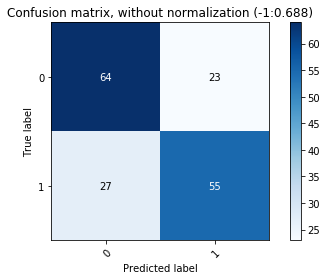

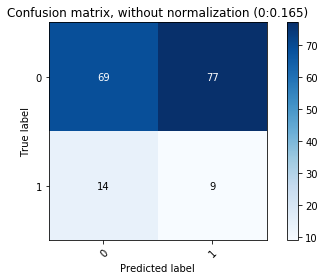

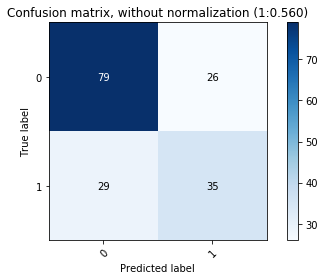

In [65]:
cm = []
for c in oal.classes_:
    y_pred = oal.clf_by_class[c].predict(X_test_transformed[c])
    y_test_transformed = oal.transform_y(y_test, c)
    cm = confusion_matrix(y_test_transformed, y_pred)
    p = cm[1,1]/sum(cm[:,1])
    r = cm[1,1]/sum(cm[1,:])
    f1 = (2.*p*r)/(p+r)
    plot_confusion_matrix(cm, [0,1], title="%d:%.3f" % (c, f1) )

In [62]:
for y, array_probs in list(zip(y_test, oal.predict_proba_weak(X_test_transformed))):
    if y == 1:
        print(y, ":", ', '.join(list(map(lambda x: "%.3f" % x, array_probs))))

1 : 0.942, 0.058, 0.466, 0.534, 0.899, 0.101
1 : 0.841, 0.159, 0.536, 0.464, 0.518, 0.482
1 : 0.818, 0.182, 0.529, 0.471, 0.905, 0.095
1 : 0.947, 0.053, 0.471, 0.529, 0.274, 0.726
1 : 0.881, 0.119, 0.546, 0.454, 0.310, 0.690
1 : 0.603, 0.397, 0.512, 0.488, 0.579, 0.421
1 : 0.800, 0.200, 0.519, 0.481, 0.744, 0.256
1 : 0.841, 0.159, 0.524, 0.476, 0.163, 0.837
1 : 0.899, 0.101, 0.479, 0.521, 0.150, 0.850
1 : 0.851, 0.149, 0.532, 0.468, 0.132, 0.868
1 : 0.875, 0.125, 0.532, 0.468, 0.219, 0.781
1 : 0.492, 0.508, 0.507, 0.493, 0.420, 0.580
1 : 0.929, 0.071, 0.475, 0.525, 0.615, 0.385
1 : 0.619, 0.381, 0.503, 0.497, 0.591, 0.409
1 : 0.646, 0.354, 0.526, 0.474, 0.124, 0.876
1 : 0.492, 0.508, 0.507, 0.493, 0.420, 0.580
1 : 0.899, 0.101, 0.469, 0.531, 0.448, 0.552
1 : 0.812, 0.188, 0.523, 0.477, 0.242, 0.758
1 : 0.492, 0.508, 0.507, 0.493, 0.420, 0.580
1 : 0.782, 0.218, 0.525, 0.475, 0.863, 0.137
1 : 0.911, 0.089, 0.526, 0.474, 0.805, 0.195
1 : 0.453, 0.547, 0.518, 0.482, 0.320, 0.680
1 : 0.718,

In [ ]:
.()

In [16]:
a = []
a.append( np.array([ [1,2], [3,2], [1,3] ]) )
a.append( np.array([ [4,5], [6,5], [4,6] ]) )
a

[array([[1, 2],
        [3, 2],
        [1, 3]]), array([[4, 5],
        [6, 5],
        [4, 6]])]

In [19]:
np.concatenate(a, axis=1)

array([[1, 2, 4, 5],
       [3, 2, 6, 5],
       [1, 3, 4, 6]])